# NLP with Disaster Tweets: Tensorflow LSTM-CNN-Glove

### Abstract

   In this notebook, I undertook the preprocessing of the dataset and tailored it for DNN training. Initially, I conducted experiments with LSTM, training the embedding layer within the network. However, this approach resulted in overfitting due to the limited size of the training data. Subsequently, I incorporated a 200-dimensional Twitter version of Stanford's [GloVe](https://nlp.stanford.edu/projects/glove/) embeddings, exploring various architectures and ultimately opting for a straightforward LSTM-CNN hybrid model. To refine the model further, I fine-tuned the hyperparameters of the LSTM-CNN hybrid using Bayesian Optimization with Keras Tuner.

   As a beginner, I welcome your comments.😊 But I kindly request that you provide constructive feedback in a gentle manner, as I am new to this and still learning. 😅 And please rate my notebook if you find it helpful. 🤗

#### Version 3 updates
* Changed activation functions & kernal initializers
* Changed metrics for eval/early-stop and the objective of keras-tunner for model selection
* Added L2 regularization to dense layers
* Added roc-auc precision-recall curve graphs to model evaluation 
* Added a seperate step for fine-tuning learning rate
* Changed hyper model to tune number of layers as well as number of hidden units and dropouts 

### Checking GPU configs

In [1]:
#Checking GPU to understand how much memory available for training
!nvidia-smi

Thu Nov 23 00:46:04 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8               9W /  80W |     12MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import subprocess as sp
import os
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

get_gpu_memory()

[3890]

### Importing useful libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [4]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
#Enabling memory growth for GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow as tf

2023-11-23 00:46:05.050783: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 00:46:05.050867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 00:46:05.052161: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import gc
import pandas as pd
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import auc, roc_curve
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt

In [7]:
# for reproducibility
seed0=1337
np.random.seed(seed0) 
tf.keras.utils.set_random_seed(seed0)
tf.config.experimental.enable_op_determinism()

In [8]:
pd.set_option('display.max_colwidth', None)

In [9]:
import string
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/pelin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
from nltk.corpus import stopwords
import re

## Preprocessing

In [11]:
df=pd.read_csv("train.csv")

In [12]:
display(df.shape)
display(df.head(5))

(7613, 5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [13]:
#splitting dataset to train-test segments for training and validation
def parse_data_from_dataframe(df):
    sentences = df['text']
    labels = df['target']
    X_train, X_test, y_train, y_test = train_test_split(sentences,
                                                  labels,
                                                  test_size=0.30,
                                                  random_state=seed0,
                                                       shuffle=True)
    
    return X_train, X_test, y_train, y_test

Source for some of the twitter specific regex: https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-using-word2vec-bilstm 

In [14]:
def remove_stopwords(sentence):
    # Replace @USERNAME to '<user>'.
    sentence = re.sub('@[^\s]+','user', sentence)
    #removing html tags
    sentence = re.sub(r'<.*?>',r'',sentence)
    # Replace all URls with '<url>'
    sentence = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "<url>", sentence)
    # Adding space on either side of '/' to seperate words (After replacing URLS).
    sentence = re.sub(r'/', ' / ', sentence)

    # Replace 3 or more consecutive letters by 2 letter.
    sentence = re.sub(r"(.)\1\1+", r"\1\1", sentence)

    sentence = re.sub(r'<.*?>',r'',sentence)
    
    # Replace all emojis.
    sentence = re.sub(r'<3', '<heart>', sentence)
    sentence = re.sub(r"[8:=;]['`\-]?[)d]+", '<smile>', sentence)
    sentence = re.sub(r"[8:=;]['`\-]?\(+", '<sadface>', sentence)
    sentence = re.sub(r"[8:=;]['`\-]?[\/|l*]", '<neutralface>', sentence)
    sentence = re.sub(r"[8:=;]['`\-]?p+", '<lolface>', sentence)
    

    #removing punctuation
    sentence  = "".join([char for char in sentence if char not in string.punctuation])
    #removing numerics
    sentence = re.sub('[0-9]+', '', sentence)
    
    #stopwords_list = list(set(stopwords.words('english')))
    #sentence=[x for x in sentence if x not in stopwords_list]
    sentence = sentence.lower().split()
    
    return " ".join(sentence)

In [15]:
X_train, X_test, y_train, y_test = parse_data_from_dataframe(df)

In [16]:
#checking samples from the dataset before preprocess
X_train[51:59]

546                                                                                             No snowflake in an avalanche ever feels responsible.
3944        Flood Advisory issued August 05 at 7:10PM CDT until August 05 at 8:00PM CDT by NWS: ...THE URBAN AND ... http://t.co/SeMw5cQ7Dg #weather
4506                     Hurricane Dancers: The First Caribbean Pirate Shipwreck\nMargarita Engle - Henry Holt and Co. (BYR). http://t.co/i7EskymOec
413                                                                 #NOWPLAYING Arsonist MC -  So Impressed -  @ARSONISTMUSIC http://t.co/1ElreH1jLJ
7420                                             Police Officer Wounded Suspect Dead After Exchanging Shots http://t.co/brE2lGmn7C #ABC #News #AN247
6766                                                                                                                      @Ayshun_Tornado then don't
2887    @POTUS you until you drown by water entering the lungs. You being alive has caused this great coun

In [17]:
X_train=X_train.apply(remove_stopwords)
X_test=X_test.apply(remove_stopwords)

In [18]:
#checking samples from the dataset after preprocess
X_train[51:59]

546                                                                                          no snowflake in an avalanche ever feels responsible
3944                                                  flood advisory issued august at pm cdt until august at pm cdt by nws the urban and weather
4506                                                hurricane dancers the first caribbean pirate shipwreck margarita engle henry holt and co byr
413                                                                                                     nowplaying arsonist mc so impressed user
7420                                                                      police officer wounded suspect dead after exchanging shots abc news an
6766                                                                                                                              user then dont
2887    user you until you drown by water entering the lungs you being alive has caused this great country to fall to shit because

In [19]:
print(f"There are {len(X_train)} sentences in the dataset.\n")

max_len_train=X_train.str.split().map(lambda x: len(x)).max()
print("Train set info:")
print(f"First sentence has {len(X_train.head(1).values[0].split())} words (after removing stopwords).\n")
print(f"Max lenght of sentence has {max_len_train} words (after removing stopwords).\n")
print(f"There are {len(y_train)} labels in the dataset.\n")
print(f"The first 5 labels are {y_train.head(5)}\n\n")

max_len_test=X_test.str.split().map(lambda x: len(x)).max()
print("Test set info:")
print(f"There are {len(X_test)} sentences in the dataset.\n")
print(f"First sentence has {len(X_test.head(1).values[0].split())} words (after removing stopwords).\n")
print(f"Max lenght of sentence has {max_len_train} words (after removing stopwords).\n")
print(f"There are {len(y_test)} labels in the dataset.\n")
print(f"The first 5 labels are {y_test.head(5)}\n\n")

There are 5329 sentences in the dataset.

Train set info:
First sentence has 17 words (after removing stopwords).

Max lenght of sentence has 32 words (after removing stopwords).

There are 5329 labels in the dataset.

The first 5 labels are 1927    0
3229    0
3505    0
6430    1
5369    0
Name: target, dtype: int64


Test set info:
There are 2284 sentences in the dataset.

First sentence has 14 words (after removing stopwords).

Max lenght of sentence has 32 words (after removing stopwords).

There are 2284 labels in the dataset.

The first 5 labels are 1948    0
5508    0
5041    0
4147    0
5108    1
Name: target, dtype: int64




In [20]:
max_length = 32
trunc_type='post'
oov_tok = "<OOV>"
padding = 'post'

In [21]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = len(X_train), oov_token=oov_tok)

In [22]:
# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [23]:
print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 12179 words

<OOV> token included in vocabulary


In [24]:
def seq_pad_and_trunc(sentences, tokenizer, padding, trunc_type, max_length):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
    return padded

In [25]:
# Generating and padding the training sequences
padded = seq_pad_and_trunc(X_train, tokenizer, padding, trunc_type, max_length)
# Generating and padding the test sequences
testing_padded = seq_pad_and_trunc(X_test, tokenizer, padding, trunc_type, max_length)

In [26]:
print('Training Set Shape = {}'.format(padded.shape))
print('Training Set Memory Usage = {:.2f} Bit'.format(padded.nbytes*8 ))
print('Test Set Shape = {}'.format(testing_padded.shape))
print('Test Set Memory Usage = {:.2f} Bit'.format(testing_padded.nbytes*8))

Training Set Shape = (5329, 32)
Training Set Memory Usage = 5456896.00 Bit
Test Set Shape = (2284, 32)
Test Set Memory Usage = 2338816.00 Bit


## Training an LSTM Model with Self-Trained Embeddings

In [27]:
# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [28]:
def call():
        es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # metrics to monitor
        min_delta=0,#min amoung to count as an improvement
        patience=20, # how many epochs before stop
        verbose=1,
        mode='min', # we need to max f1
        restore_best_weights=True)
            
        rp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1,
        mode='min',
        min_lr=1e-8)
        
        return es,rp
callbacks = call()

In [29]:
activation = LeakyReLU(alpha = 0.01)

In [30]:
# Parameters
embedding_dim = 32
lstm_dim = 32
dense_dim = 64

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, dropout=0.2, 
                                                       kernel_initializer = 'orthogonal')),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(dense_dim,kernel_initializer = 'he_normal',
                          kernel_regularizer = regularizers.l2(1e-4), 
                          activation=activation),
    tf.keras.layers.Dense(1,kernel_regularizer = regularizers.l2(1e-4), 
                          activation='sigmoid')
])

# Setting the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.experimental.Nadam(),
                   metrics=[tfa.metrics.FBetaScore(name='f1_score',num_classes=1,
                                                average='macro',threshold=0.5)])
#metrics=[tfa.metrics.FBetaScore(name='f1_score',num_classes=1,average='macro',threshold=0.5)]
# Printing the model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 32)            389728    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 410593 (1.57 MB)
Trainable params: 410593 (1.57 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [31]:
NUM_EPOCHS = 100
BATCH_SIZE = 128

# Training the model
history_lstm = model_lstm.fit(padded, y_train, 
                              batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                              callbacks=[callbacks],
                              validation_data=(testing_padded, y_test))

Epoch 1/100
42/42 [==============================] - 17s 288ms/step - loss: 0.6926 - f1_score: 0.0634 - val_loss: 0.6722 - val_f1_score: 0.0408 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - 9s 222ms/step - loss: 0.5522 - f1_score: 0.6481 - val_loss: 0.4801 - val_f1_score: 0.7557 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - 8s 182ms/step - loss: 0.3763 - f1_score: 0.8159 - val_loss: 0.5030 - val_f1_score: 0.7203 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - 6s 142ms/step - loss: 0.2924 - f1_score: 0.8621 - val_loss: 0.4907 - val_f1_score: 0.7595 - lr: 0.0010
Epoch 5/100
42/42 [==============================] - 4s 97ms/step - loss: 0.2387 - f1_score: 0.8962 - val_loss: 0.5647 - val_f1_score: 0.7410 - lr: 0.0010
Epoch 6/100
42/42 [==============================] - 5s 117ms/step - loss: 0.2057 - f1_score: 0.9165 - val_loss: 0.5888 - val_f1_score: 0.7395 - lr: 0.0010
Epoch 7/100
42/42 [==============================] - ETA: 0s - l

### Assessing Model Performance

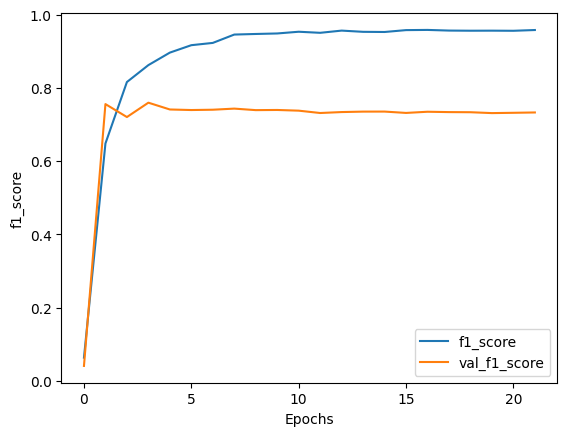

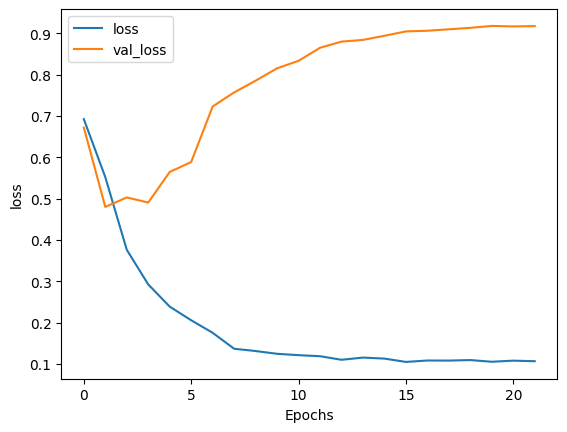

In [32]:
# Plotting the accuracy and loss history
plot_graphs(history_lstm, 'f1_score')
plot_graphs(history_lstm, 'loss')

72/72 [==============================] - 1s 4ms/step
****** Test Data ********
F1: 0.7556675062972291
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1275
           1       0.77      0.74      0.76      1009

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284

Confusion Matrix


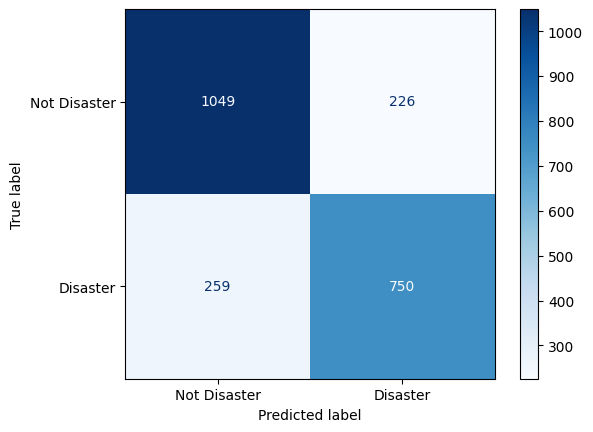

In [33]:
y_pred_valid = tf.math.round(model_lstm.predict(testing_padded)).numpy().astype(int) 
print("****** Test Data ********")
print(f"F1: {metrics.f1_score(y_test, y_pred_valid)}")
# Printing performance details
print(metrics.classification_report(y_test, y_pred_valid))

# Printing confusion matrix
print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_valid,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

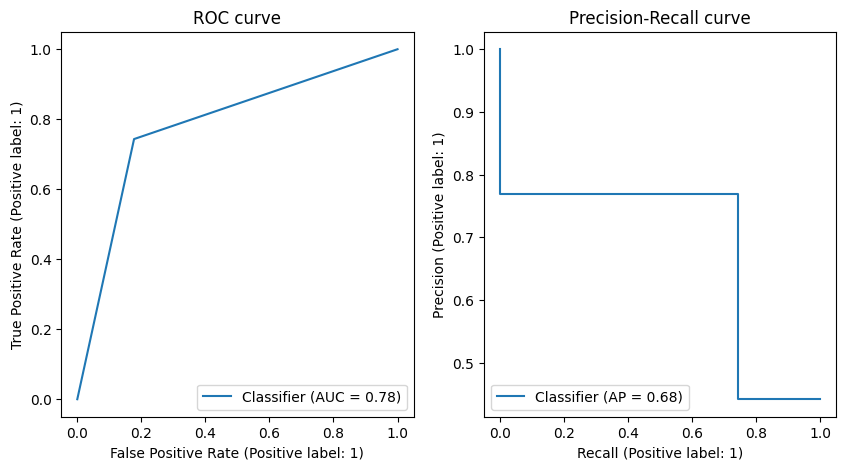

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

roc_display = RocCurveDisplay.from_predictions(y_test, y_pred_valid,ax=ax1)
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_valid,ax=ax2)
roc_display.ax_.set_title("ROC curve")
pr_display.ax_.set_title("Precision-Recall curve")

plt.show()
plt.close()

Upon evaluating the model, it becomes evident that there is a pronounced overfitting issue to the training set, particularly in the initial epochs. This can be attributed to the constraint posed by the limited size of the training data. Given the challenges associated with small datasets, a pragmatic strategy is to leverage transfer learning. In my approach, I aim to enhance performance by transferring embeddings generated through training on a larger dataset.

In [35]:
#Resets all state generated by Keras.
tf.keras.backend.clear_session()
del model_lstm
del history_lstm

## Building an LSTM-CNN Model with GloVe Embedding Transfer for Training

Using the 200 dimension Twitter version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [36]:
#!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

In [37]:
#!unzip -q glove.twitter.27B.zip

In [38]:
GLOVE_EMBEDDINGS = {}

# Reading the file and filling GLOVE_EMBEDDINGS with its contents
with open("glove.twitter.27B.200d.txt") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs
print("Found %s word vectors." % len(GLOVE_EMBEDDINGS))

Found 1193514 word vectors.


In [39]:
test_word = 'sadface'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word sadface looks like this:

[ 0.13942    0.14942   -0.083049  -0.22694   -0.17719    0.068621
  0.32751    0.29046   -0.98112   -0.055128  -0.32885   -0.028781
  0.13015   -0.62901   -0.26694   -0.49831   -0.028981   0.53447
 -0.74758    0.46059    0.20023   -0.52688    0.88961    0.20244
 -0.3154     0.76178   -0.097853   0.051232   0.31198    0.28984
 -0.33384    0.79756    0.020365  -0.48581    0.22673    0.08533
  0.5413     0.032684   0.34624   -0.0050298  0.69359    0.79652
  0.36373   -0.026102  -0.25161    0.94031    0.35078   -0.27898
 -0.016592   0.4419     0.33657    0.22511   -0.14285   -0.12429
  0.32822    0.23203    0.22721    0.40608   -0.088886   0.10732
  0.024414  -0.47135    0.35159   -0.20438   -0.59589   -0.17563
 -0.01621    0.0184    -0.0043566 -0.14127    0.52329   -0.30056
  0.17157   -0.069917   0.21397    0.04184   -0.33831   -0.40201
 -0.098991   0.69844   -0.061859  -0.21282    0.2322     0.077196
 -0.17289   -0.014947   0.09605

In [40]:
EMBEDDING_DIM = 200
# Initializing an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((vocab_size+1, EMBEDDING_DIM))

# Iterating all of the words in the vocabulary and if the vector representation for 
# the word exists within GloVe's representations, saving it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [41]:
embedding_layer = tf.keras.layers.Embedding(
    vocab_size+1,
    EMBEDDING_DIM,
    input_length=max_length, 
    weights=[EMBEDDINGS_MATRIX], 
    trainable=False
)

### Tunning learning rate

In [42]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

In [43]:
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200,dropout=0.50,
                                                       kernel_initializer = 'orthogonal',
                                                       return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.50,
                                                       kernel_initializer = 'orthogonal',
                                                       return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Conv1D(200, 5, activation=activation),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(100, kernel_initializer = 'he_normal',
                          kernel_regularizer = regularizers.l2(1e-5), 
                          activation=activation),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(50, kernel_initializer = 'he_normal',
                          kernel_regularizer = regularizers.l2(1e-5),
                          activation=activation),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(1, kernel_regularizer = regularizers.l2(1e-5), 
                          activation='sigmoid')
])


# Setting the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.experimental.Nadam(),
                   metrics=[tfa.metrics.FBetaScore(name='f1_score',num_classes=1,
                                                average='macro',threshold=0.5)])

# Printing the model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 200)           2436000   
                                                                 
 spatial_dropout1d (Spatial  (None, 32, 200)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 32, 400)           641600    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 400)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32, 200)           400800    
 onal)                                                           
                                                        

In [44]:
NUM_EPOCHS = 100
BATCH_SIZE = 64

# Training the model
history_lstm = model_lstm.fit(padded, y_train, 
                              batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                              callbacks=[lr_schedule ],
                              validation_data=(testing_padded, y_test))

Epoch 1/100
84/84 [==============================] - 8s 32ms/step - loss: 0.7170 - f1_score: 0.5338 - val_loss: 0.6946 - val_f1_score: 0.6147 - lr: 1.0000e-06
Epoch 2/100
84/84 [==============================] - 2s 23ms/step - loss: 0.7112 - f1_score: 0.5179 - val_loss: 0.6903 - val_f1_score: 0.6126 - lr: 1.1220e-06
Epoch 3/100
84/84 [==============================] - 2s 24ms/step - loss: 0.7031 - f1_score: 0.5222 - val_loss: 0.6863 - val_f1_score: 0.4431 - lr: 1.2589e-06
Epoch 4/100
84/84 [==============================] - 2s 23ms/step - loss: 0.6992 - f1_score: 0.4904 - val_loss: 0.6829 - val_f1_score: 0.2931 - lr: 1.4125e-06
Epoch 5/100
84/84 [==============================] - 2s 24ms/step - loss: 0.6946 - f1_score: 0.4694 - val_loss: 0.6798 - val_f1_score: 0.1951 - lr: 1.5849e-06
Epoch 6/100
84/84 [==============================] - 2s 23ms/step - loss: 0.6850 - f1_score: 0.4687 - val_loss: 0.6770 - val_f1_score: 0.1440 - lr: 1.7783e-06
Epoch 7/100
84/84 [===========================

(1e-06, 0.001, 0.0, 1.0)

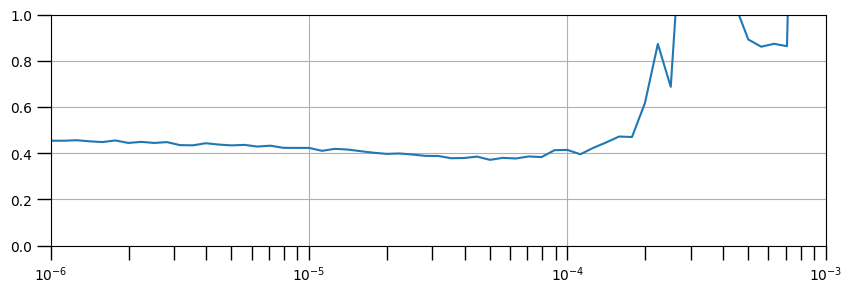

In [45]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
# Set the figure size
plt.figure(figsize=(10, 3))
plt.grid(True)
plt.semilogx(lrs, history_lstm.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-6, 1e-3, 0, 1])

(1e-05, 0.0002, 0.0, 1.0)

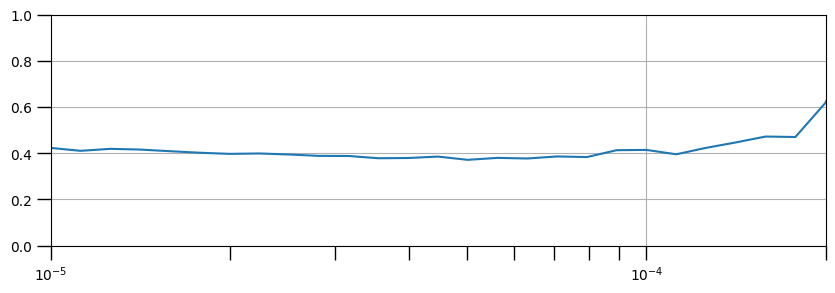

In [46]:
## Zooming in to 1e-5 & 2e-4 range to read the optimum learning rate
plt.figure(figsize=(10, 3))
plt.grid(True)
plt.semilogx(lrs, history_lstm.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-5, 2e-4, 0, 1])

In [47]:
#Resets all state generated by Keras.
tf.keras.backend.clear_session()
del model_lstm
del history_lstm

### Building Model 

In [48]:
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200,dropout=0.50,
                                                       kernel_initializer = 'orthogonal',
                                                       return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.50,
                                                       kernel_initializer = 'orthogonal',
                                                       return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Conv1D(200, 5, activation=activation),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(100,kernel_initializer = 'he_normal', 
                          kernel_regularizer = regularizers.l2(1e-5),
                          activation=activation),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(50,kernel_initializer = 'he_normal',
                          kernel_regularizer = regularizers.l2(1e-5), 
                          activation=activation),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(1,kernel_regularizer = regularizers.l2(1e-5), 
                          activation='sigmoid')
])

learning_rate= 5e-5

# Setting the training parameters
model_lstm.compile(loss='binary_crossentropy',
                   optimizer=tf.keras.optimizers.experimental.Nadam(learning_rate=learning_rate),
                   metrics=[tfa.metrics.FBetaScore(name='f1_score',num_classes=1,
                                                average='macro',threshold=0.5)])

# Printing the model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 200)           2436000   
                                                                 
 spatial_dropout1d (Spatial  (None, 32, 200)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 32, 400)           641600    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 400)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32, 200)           400800    
 onal)                                                           
                                                        

In [49]:
NUM_EPOCHS = 100
BATCH_SIZE = 64

# Training the model
history_lstm = model_lstm.fit(padded, y_train, 
                              batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                              callbacks=[callbacks],
                              validation_data=(testing_padded, y_test))

Epoch 1/100
84/84 [==============================] - 6s 30ms/step - loss: 0.6645 - f1_score: 0.4075 - val_loss: 0.6142 - val_f1_score: 0.7074 - lr: 5.0000e-05
Epoch 2/100
84/84 [==============================] - 2s 23ms/step - loss: 0.5725 - f1_score: 0.6632 - val_loss: 0.5101 - val_f1_score: 0.7378 - lr: 5.0000e-05
Epoch 3/100
84/84 [==============================] - 2s 22ms/step - loss: 0.5175 - f1_score: 0.7165 - val_loss: 0.4834 - val_f1_score: 0.7445 - lr: 5.0000e-05
Epoch 4/100
84/84 [==============================] - 2s 22ms/step - loss: 0.4972 - f1_score: 0.7198 - val_loss: 0.4770 - val_f1_score: 0.7631 - lr: 5.0000e-05
Epoch 5/100
84/84 [==============================] - 2s 20ms/step - loss: 0.4848 - f1_score: 0.7248 - val_loss: 0.4623 - val_f1_score: 0.7610 - lr: 5.0000e-05
Epoch 6/100
84/84 [==============================] - 2s 19ms/step - loss: 0.4716 - f1_score: 0.7275 - val_loss: 0.4650 - val_f1_score: 0.7677 - lr: 5.0000e-05
Epoch 7/100
84/84 [===========================

### Assessing Model Performance

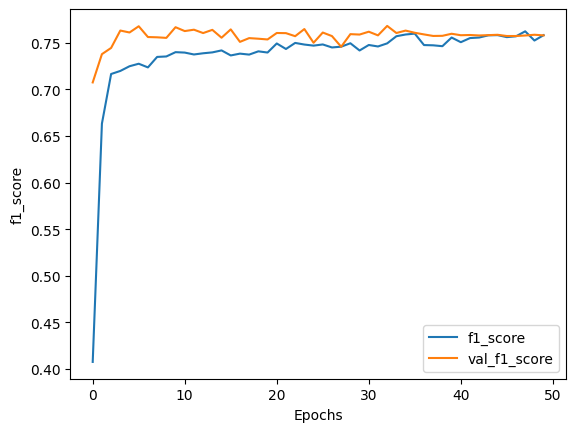

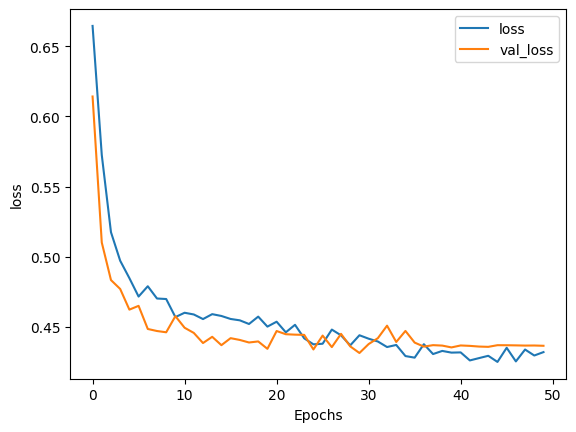

In [50]:
# Plotting the accuracy and loss history
plot_graphs(history_lstm, 'f1_score')
plot_graphs(history_lstm, 'loss')

72/72 [==============================] - 1s 7ms/step
****** Test Data ********
F1: 0.7588046958377801
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1275
           1       0.82      0.70      0.76      1009

    accuracy                           0.80      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.80      0.80      0.80      2284

Confusion Matrix


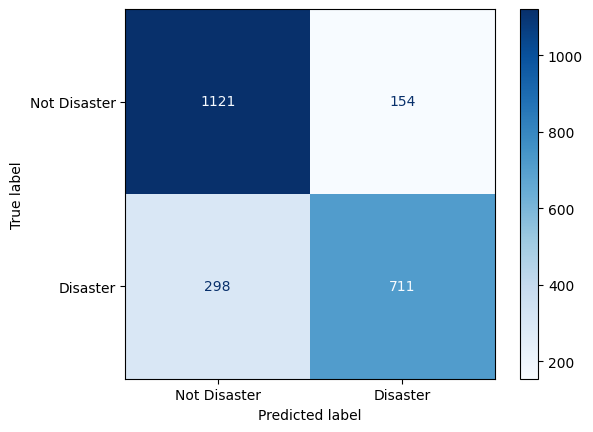

In [51]:
y_pred_valid = tf.math.round(model_lstm.predict(testing_padded)).numpy().astype(int) 
print("****** Test Data ********")
print(f"F1: {metrics.f1_score(y_test, y_pred_valid)}")
# Printing performance details
print(metrics.classification_report(y_test, y_pred_valid))

# Printing confusion matrix
print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_valid,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

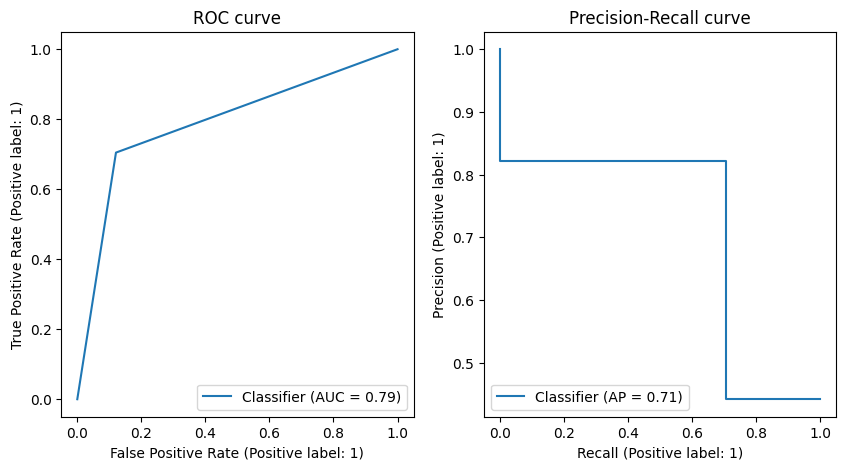

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

roc_display = RocCurveDisplay.from_predictions(y_test, y_pred_valid,ax=ax1)
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_valid,ax=ax2)
roc_display.ax_.set_title("ROC curve")
pr_display.ax_.set_title("Precision-Recall curve")

plt.show()
plt.close()

### Predicting Test Set Outcomes

In [53]:
#reading and pre-processing the test dataset 
df_test=pd.read_csv("test.csv")
sentences_test = df_test['text']
sentences_test=sentences_test.apply(remove_stopwords)
df_test_padded = seq_pad_and_trunc(sentences_test, tokenizer, padding, trunc_type, max_length)

In [54]:
# storing predictions in to a dataframe and writing to a csv file
#embedded_out=pd.DataFrame(columns=['id', 'target'])
#embedded_out['id']=df_test['id']
#embedded_out['target'] = tf.math.round(model_lstm.predict(df_test_padded)).numpy().astype(int) 
#embedded_out.to_csv('submission.csv', index=False)
#print("Your submission was successfully saved!")

In [55]:
tf.keras.backend.clear_session()
del model_lstm
del history_lstm

## Optimizing Hyperparameters for LSTM-CNN-GloVe Embeddings Model through Bayesian Tuning

In [56]:
#tf.keras.backend.clear_session()
#del tuner_lr_do 
#del best_hps
#del tunned_model_lstm
#del final_model

In [57]:
def call():
        es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # metrics to monitor
        min_delta=0,#min amoung to count as an improvement
        patience=10, # how many epochs before stop
        verbose=0,
        mode='min', # we need to max f1
        restore_best_weights=True)
            
        rp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=0,
        mode='min',
        min_lr=1e-8)
        
        return es,rp
callbacks = call()

In [58]:
#adding callback to utilize tensorboard to observe search
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir="tb_logs")
#adding callback to clear keras backend after each training run
class ClearMemory(Callback):
    def on_train_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

In [59]:
def model_builder(hp):
    hp_units1 = hp.Int('units1', min_value=50,max_value=200,step=50, default=200)
    hp_units2 = hp.Int('units2', min_value=0,max_value=200,step=50, default=100)
    hp_units3 = hp.Int('units3', min_value=0,max_value=200,step=50, default=200)
    hp_units4 = hp.Int('units4', min_value=0,max_value=200,step=50, default=100)
    hp_units5 = hp.Int('units5', min_value=0,max_value=200,step=50, default=50)
    
    hp_dropout1=hp.Float('drop_out1', min_value=0,max_value=0.5,step=0.05, default=0.2)
    hp_dropout2=hp.Float('drop_out2', min_value=0,max_value=0.5,step=0.05, default=0.5)
    hp_dropout3=hp.Float('drop_out3', min_value=0,max_value=0.5,step=0.05, default=0.2)
    hp_dropout4=hp.Float('drop_out4', min_value=0,max_value=0.5,step=0.05, default=0.5)
    hp_dropout5=hp.Float('drop_out5', min_value=0,max_value=0.5,step=0.05, default=0.2)
    hp_dropout6=hp.Float('drop_out6', min_value=0,max_value=0.5,step=0.05, default=0.2)
    hp_dropout7=hp.Float('drop_out7', min_value=0,max_value=0.5,step=0.05, default=0.2)
    hp_dropout8=hp.Float('drop_out8', min_value=0,max_value=0.5,step=0.05, default=0.2)
    
    hp_regularizer1= hp.Choice('reg1',values=[1e-4, 1e-5, 1e-6])
    hp_regularizer2= hp.Choice('reg2',values=[1e-4, 1e-5, 1e-6])
    hp_regularizer3= hp.Choice('reg3',values=[1e-4, 1e-5, 1e-6])
    
    model = tf.keras.Sequential()
    model.add(embedding_layer)
    
    model.add(tf.keras.layers.SpatialDropout1D(hp_dropout1))
    
    if (hp_units2 !=0) or (hp_units3 !=0):
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp_units1,dropout=hp_dropout2,
                                                                     kernel_initializer = 'orthogonal',
                                                                 return_sequences=True)))
        model.add(tf.keras.layers.Dropout(hp_dropout3))
    else:
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp_units1,dropout=hp_dropout2,
                                                                     kernel_initializer = 'orthogonal')))
         
    if hp_units2 !=0:
        if hp_units3 !=0:
            model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp_units2, dropout=hp_dropout4,
                                                                         kernel_initializer = 'orthogonal',
                                                                     return_sequences=True)))
            model.add(tf.keras.layers.Dropout(hp_dropout5))
        else:
            model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp_units2, dropout=hp_dropout4,
                                                                         kernel_initializer = 'orthogonal')))
        
    if hp_units3 !=0:
        model.add(tf.keras.layers.Conv1D(hp_units3, 5, activation=activation))
        model.add(tf.keras.layers.GlobalMaxPool1D())
    

    model.add(tf.keras.layers.Dropout(hp_dropout6))
    
    if hp_units4 !=0:
        model.add(tf.keras.layers.Dense(hp_units4,kernel_initializer = 'he_normal',
                                        kernel_regularizer = regularizers.l2(hp_regularizer1),
                                        activation=activation))
        model.add(tf.keras.layers.Dropout(hp_dropout7))
    
    if hp_units5 !=0:
        model.add(tf.keras.layers.Dense(hp_units5,kernel_initializer = 'he_normal',
                                        kernel_regularizer = regularizers.l2(hp_regularizer2),
                                        activation=activation))
        model.add(tf.keras.layers.Dropout(hp_dropout8))
    
    model.add(tf.keras.layers.Dense(1,kernel_regularizer = regularizers.l2(hp_regularizer3), 
                                    activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                       optimizer=tf.keras.optimizers.experimental.Nadam(learning_rate=5e-5),
                   metrics=[tfa.metrics.FBetaScore(name='f1_score',num_classes=1,
                                                average='macro',threshold=0.5)])
    return model

    Due to the limited GPU memory in my local environment, I'm unable to train models that require more than 3887 MiB, which is equivalent to 4075.81 MB of GPU memory. While not all layers of the network will be fully connected, the optimization method will necessitate the calculation of second-order momentum, which is more resource-intensive than simple SGD.

    The previous model, despite consuming approximately 600 MB of GPU memory during training, incorporated a significant amount of dropout. Consequently, I plan to decrease the batch size. This adjustment will allow me to experiment with larger and more densely connected models. Additionally, I aim to estimate the maximum parameters to avoid training models that could overwhelm the kernel during training.

In [60]:
total_limit=4075.81*8000000
max_param_Bsize_32=int(total_limit/(padded.nbytes*8/(padded.shape[0]/32)))
max_param_Bsize_64=int(total_limit/(padded.nbytes*8/(padded.shape[0]/64)))
max_param_Bsize_128=int(total_limit/(padded.nbytes*8/(padded.shape[0]/128)))
print("GPU memory bottleneck in terms of # of params for gradient calculation for fully connected models")
print(f"# of parameters, batch size 32: {max_param_Bsize_32}")
print(f"# of parameters, batch size 64: {max_param_Bsize_64}")
print(f"# of parameters, batch size 128: {max_param_Bsize_128}")

GPU memory bottleneck in terms of # of params for gradient calculation for fully connected models
# of parameters, batch size 32: 995070
# of parameters, batch size 64: 497535
# of parameters, batch size 128: 248767


In [61]:
tuner_lr_do = kt.BayesianOptimization(hypermodel=model_builder,
                                        objective=kt.Objective('val_loss', direction='min'),
                                        max_trials=100,
                                        seed=seed0,      
                                        overwrite=False,#True,
                                        directory='my_dir',
                                        max_model_size=3815000, # skipping oversized models
                                        max_consecutive_failed_trials=1, #not repeating failed trials
                                        project_name='lr_do_to_kt')

Reloading Tuner from my_dir/lr_do_to_kt/tuner0.json


In [62]:
NUM_EPOCHS = 100
BATCH_SIZE = 64 #decreased to be able to fit larger models in to gpu memory 
tuner_lr_do.search(padded, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                              callbacks=[callbacks,tensorboard_callback,ClearMemory()],verbose=0,
                              validation_data=(testing_padded, y_test))

In [63]:
best_hps=tuner_lr_do.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.\n The optimal drop-out1 is {best_hps.get('drop_out1')}
\n The optimal units1 is {best_hps.get('units1')} 
\n The optimal drop-out2 is {best_hps.get('drop_out2')} 
\n The optimal drop-out3 is {best_hps.get('drop_out3')} 
\n The optimal units2 is {best_hps.get('units2')} 
\n The optimal drop-out4 is {best_hps.get('drop_out4')} 
\n The optimal drop-out5 is {best_hps.get('drop_out5')} 
\n The optimal units3 is {best_hps.get('units3')} 
\n The optimal drop-out6 is {best_hps.get('drop_out6')} 
\n The optimal units4 is {best_hps.get('units4')} 
\n The optimal drop-out7 is {best_hps.get('drop_out7')} 
\n The optimal units5 is {best_hps.get('units5')} 
\n The optimal drop-out8 is {best_hps.get('drop_out8')} 
\n The optimal reg1 is {best_hps.get('reg1')} 
\n The optimal reg2 is {best_hps.get('reg2')}
\n The optimal reg3 is {best_hps.get('reg3')}
""")


The hyperparameter search is complete.
 The optimal drop-out1 is 0.0

 The optimal units1 is 50 

 The optimal drop-out2 is 0.35000000000000003 

 The optimal drop-out3 is 0.45 

 The optimal units2 is 200 

 The optimal drop-out4 is 0.45 

 The optimal drop-out5 is 0.0 

 The optimal units3 is 50 

 The optimal drop-out6 is 0.45 

 The optimal units4 is 0 

 The optimal drop-out7 is 0.45 

 The optimal units5 is 0 

 The optimal drop-out8 is 0.0 

 The optimal reg1 is 1e-06 

 The optimal reg2 is 1e-06

 The optimal reg3 is 1e-06



In [64]:
tf.keras.backend.clear_session()

In [65]:
tunned_model_lstm=tuner_lr_do.hypermodel.build(best_hps)
tunned_model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 200)           2436000   
                                                                 
 spatial_dropout1d (Spatial  (None, 32, 200)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 32, 100)           100400    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 100)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32, 400)           481600    
 onal)                                                           
                                                        

In [66]:
final_model=tunned_model_lstm.fit(padded, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                              callbacks=[callbacks],
                              validation_data=(testing_padded, y_test))

Epoch 1/100
84/84 [==============================] - 8s 35ms/step - loss: 0.6530 - f1_score: 0.3310 - val_loss: 0.6137 - val_f1_score: 0.6387 - lr: 5.0000e-05
Epoch 2/100
84/84 [==============================] - 2s 22ms/step - loss: 0.5744 - f1_score: 0.6521 - val_loss: 0.5188 - val_f1_score: 0.7236 - lr: 5.0000e-05
Epoch 3/100
84/84 [==============================] - 2s 22ms/step - loss: 0.5198 - f1_score: 0.7068 - val_loss: 0.4842 - val_f1_score: 0.7359 - lr: 5.0000e-05
Epoch 4/100
84/84 [==============================] - 2s 22ms/step - loss: 0.4983 - f1_score: 0.7145 - val_loss: 0.4689 - val_f1_score: 0.7438 - lr: 5.0000e-05
Epoch 5/100
84/84 [==============================] - 2s 22ms/step - loss: 0.4779 - f1_score: 0.7349 - val_loss: 0.4612 - val_f1_score: 0.7494 - lr: 5.0000e-05
Epoch 6/100
84/84 [==============================] - 2s 21ms/step - loss: 0.4731 - f1_score: 0.7362 - val_loss: 0.4612 - val_f1_score: 0.7612 - lr: 5.0000e-05
Epoch 7/100
84/84 [===========================

### Assessing Model Performance

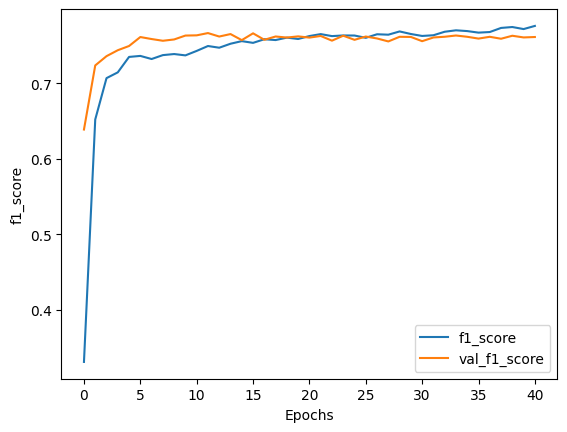

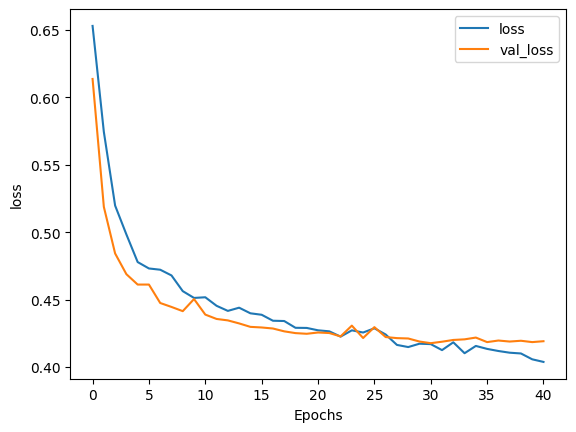

In [67]:
# Plotting the accuracy and loss history
plot_graphs(final_model, 'f1_score')
plot_graphs(final_model, 'loss')

72/72 [==============================] - 1s 7ms/step
****** Test Data ********
F1: 0.7557455905932655
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1275
           1       0.82      0.70      0.76      1009

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284

Confusion Matrix


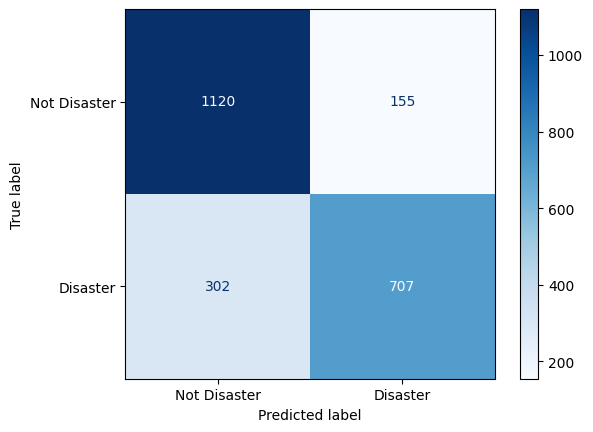

In [68]:
y_pred_valid = tf.math.round(tunned_model_lstm.predict(testing_padded)).numpy().astype(int) 
print("****** Test Data ********")
print(f"F1: {metrics.f1_score(y_test, y_pred_valid)}")
# Printing performance details
print(metrics.classification_report(y_test, y_pred_valid))

# Printing confusion matrix
print("Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_valid,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

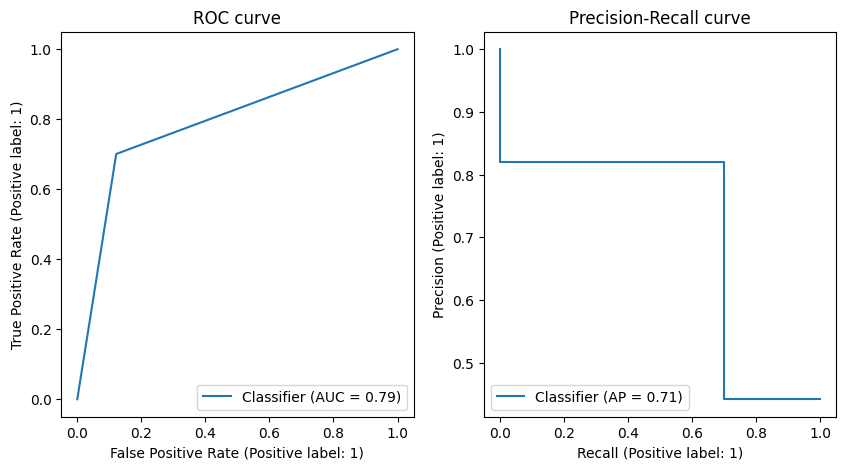

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

roc_display = RocCurveDisplay.from_predictions(y_test, y_pred_valid,ax=ax1)
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_valid,ax=ax2)
roc_display.ax_.set_title("ROC curve")
pr_display.ax_.set_title("Precision-Recall curve")

plt.show()
plt.close()

### Exploring Misclassifications: A Glimpse into Incorrect Classifications

In [70]:
#checking misclasifications
maxtoshow=10
flattened_preds=y_pred_valid.flatten()
np_y_test=y_test.to_numpy()
np_X_test=X_test.to_numpy()
errors = flattened_preds != np_y_test
counter=0
for i in range(X_test.shape[0]):
    if counter>=maxtoshow:
        break   
    if errors[i]:
        print("*"*66)
        print(f"predicted: {flattened_preds[i]} , actual: {np_y_test[i]}")
        print(np_X_test[i])
        counter+=1

******************************************************************
predicted: 0 , actual: 1
photo blue by user source
******************************************************************
predicted: 0 , actual: 1
user smile well i think that sounds like a fine plan where little derailment is possible so i applaud you smile
******************************************************************
predicted: 0 , actual: 1
there was a small earthquake in la but dont worry emily rossum is fine difficultpeople is great
******************************************************************
predicted: 1 , actual: 0
coastal german shepherd rescue oc shared a link ecstatic rescued racco animalrescue
******************************************************************
predicted: 1 , actual: 0
panic attacks are the worst
******************************************************************
predicted: 1 , actual: 0
nikoniko breaking news unconfirmed i just heard a loud bang nearby in what appears to be a blast of wi

### Predicting Test Set Outcomes

In [71]:
# storing predictions in to a dataframe and writing to a csv file
final_out=pd.DataFrame(columns=['id', 'target'])
final_out['id']=df_test['id']
final_out['target'] = tf.math.round(tunned_model_lstm.predict(df_test_padded)).numpy().astype(int) 
final_out.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

102/102 [==============================] - 1s 6ms/step
Your submission was successfully saved!
